## Set up and analyze a rate structure

**Part 1:** Shows how to set up a new rate schedule, export it as JSON, and create a new schedule from a saved JSON string.

**Part 2:** Does some basic analysis of that rate schedule on households from one county in ResStock.

**Part 3:** A slightly more complex example with off peak rate defined for all holidays and weekends. 

## Part 1: Define and save a rate structure

In [0]:
import sys
from IPython.display import display, HTML
sys.path.append("../../src")

from rates.rate_widgets import RateScheduleWidget
from rates.rate_structure import RateSchedule

In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Set up a new rate schedule.
#
# This starts with the schedule stored in example_sched.json.
#
# To instead start with an empty schedule, use:
# widget = RateScheduleWidget()
widget = RateScheduleWidget(rate_schedule=RateSchedule.from_json_file("example_sched.json"))

In [0]:
# Get the RateSchedule object out of the widget.
schedule = widget.get_rate_schedule()

In [0]:
# Save the schedule as a JSON string.
# This can be saved to a file or copied into your source code.
schedule_json = schedule.to_json()
print(schedule_json)

{"rates": [{"volumetric_rate": 0.1, "name": "Base rate", "tou_start_hour": 0, "tou_end_hour": 24, "seasonal_start_month": 1, "seasonal_end_month": 13, "days_applicable": "all days"}, {"volumetric_rate": 0.2, "name": "Summer rate", "tou_start_hour": 0, "tou_end_hour": 24, "seasonal_start_month": 6, "seasonal_end_month": 10, "days_applicable": "all days"}, {"volumetric_rate": 0.4, "name": "Weekday peak rate", "tou_start_hour": 16, "tou_end_hour": 20, "seasonal_start_month": 1, "seasonal_end_month": 13, "days_applicable": "weekdays only"}, {"volumetric_rate": 0.3, "name": "Weekend/holiday peak rate", "tou_start_hour": 16, "tou_end_hour": 20, "seasonal_start_month": 1, "seasonal_end_month": 13, "days_applicable": "weekends/holidays only"}], "monthly_fixed_charge": 10.0}


In [0]:
# Create a new RateSchedule from the JSON string.
new_rate = RateSchedule.from_json(schedule_json)
# Show the schedule in a nice table.
display(HTML(new_rate.schedule_html))

In [0]:
# Alternatively: Save the schedule as JSON in a file.
schedule.to_json_file("test_sched.json")

## Part 2: Model the rate's effect on households

Note: This example *does not* use the weekend/holiday rates you may have set above.

In [0]:
from rates.modeled_rate import ModeledRate, ModeledRateWithWeekendHoliday
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd

In [0]:
# Load sample load profiles
# Usually, these will be pulled from `building_model.resstock_ra_outputs_hourly`, but
# here we use some sample data saved to a CSV.
load_profile_df = pd.read_csv("resstock_electric_load_profile_baseline_sample.csv")

# Apply the rate to the load profiles and calculate annual bills.
model = ModeledRate(load_profile_df, schedule)
bills = model.calculate_annual_bills()

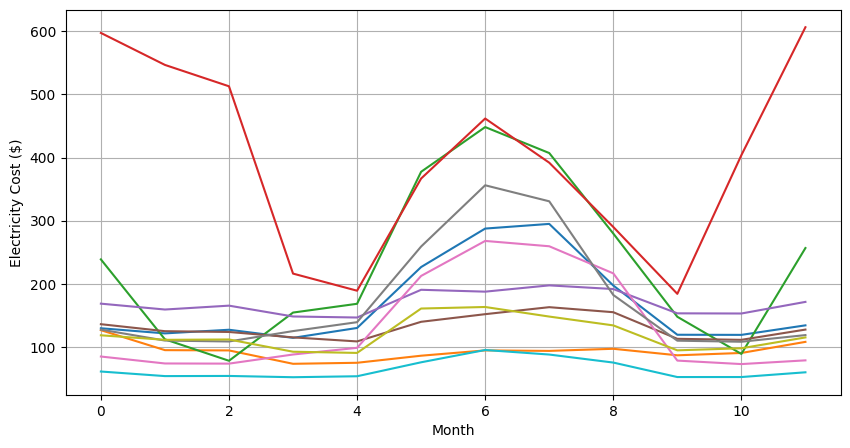

In [0]:
# Plot the results

# One line for each home, showing monthly bills over the course of a year
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model.calculate_monthly_bills().T, linestyle="-")

# Setting axis labels
ax.set_xlabel("Month")
ax.set_ylabel("Electricity Cost ($)")

plt.grid(True)
plt.show()

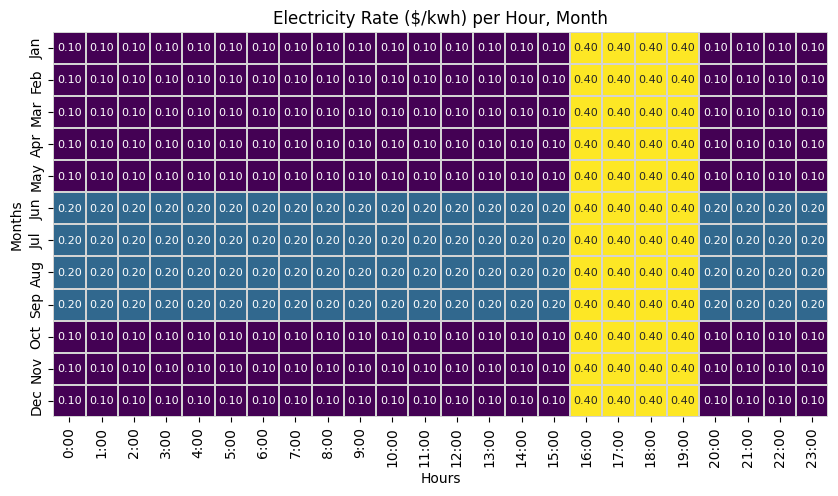

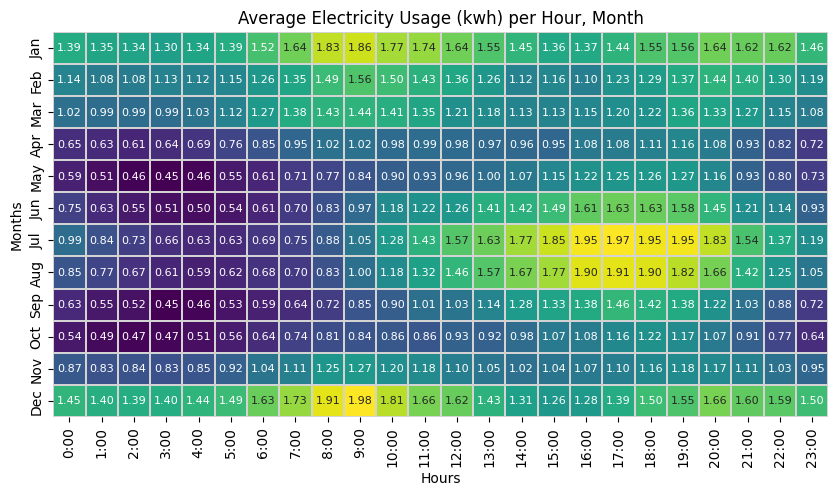

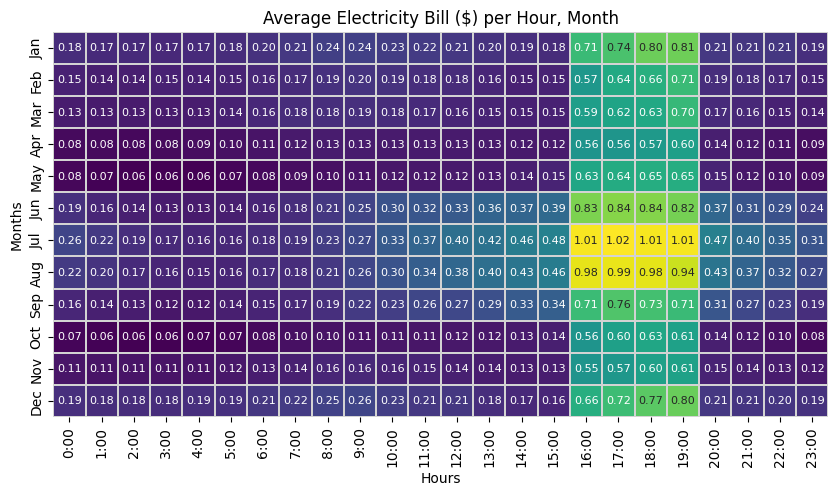

In [0]:
# plot the rates, the average load profile and the average charges as matrices
fig = model.plot_matrix_by_month_hour(model.rate_matrix, plot_title = "Electricity Rate ($/kwh) per Hour, Month")
fig = model.plot_matrix_by_month_hour(np.mean(np.mean(model.load_profile_matrix, axis = -1), axis=0), plot_title = "Average Electricity Usage (kwh) per Hour, Month")
fig = model.plot_matrix_by_month_hour(np.mean(model.bills_by_building_month_hour/24, axis = 0), plot_title = "Average Electricity Bill ($) per Hour, Month")
plt.show()

## Part 3: Differentiated weekend/holiday rates

In many cases, the rates differ on holidays and weekends. In this example, we inspect the weekend/holiday rates set in the widget above.

Text(0.5, 1.0, 'Distribution of Annual Household Electricity Bills Under Rate')

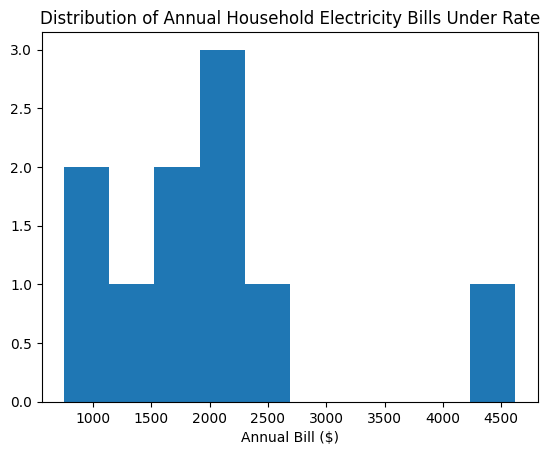

In [0]:
model = ModeledRateWithWeekendHoliday(load_profile_df, schedule)

bills = model.calculate_annual_bills()

# Plot histogram of annual bills
plt.hist(bills)
plt.xlabel("Annual Bill ($)")
plt.title("Distribution of Annual Household Electricity Bills Under Rate")

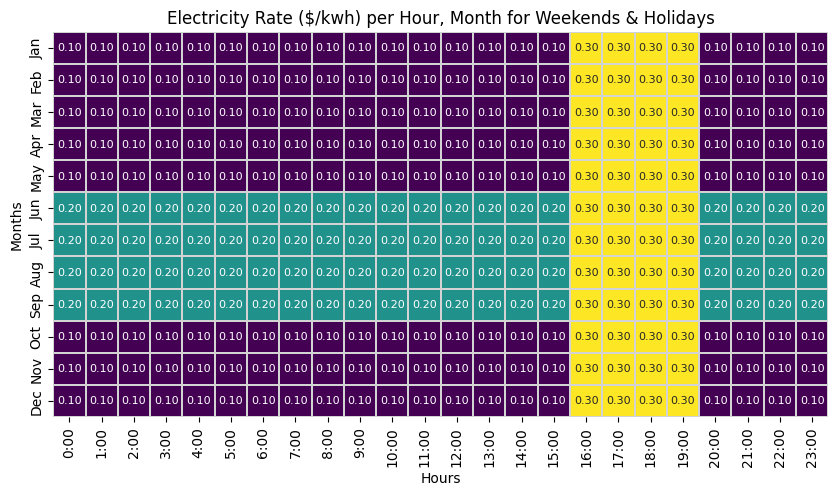

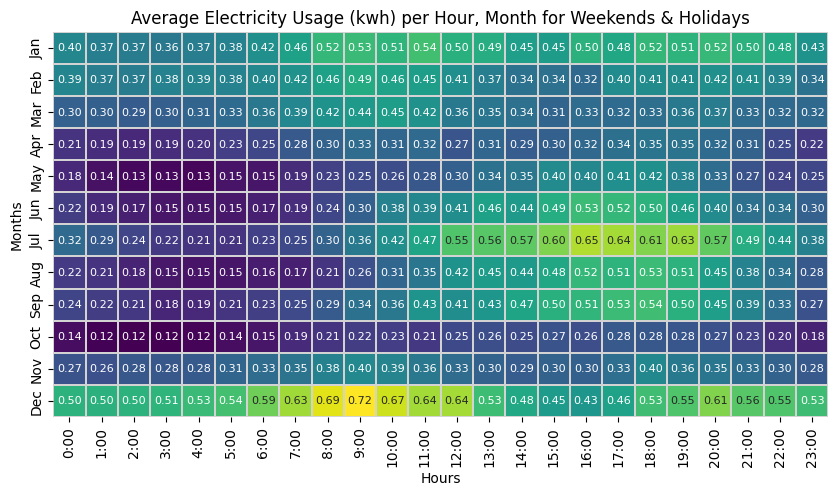

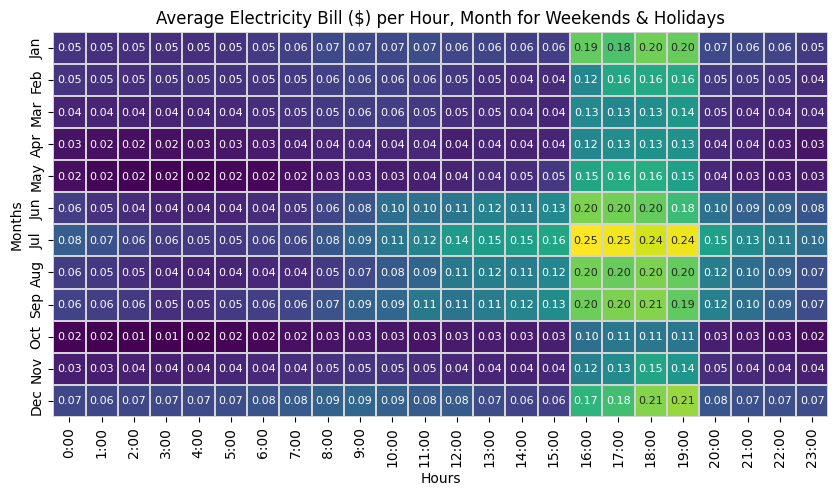

In [0]:
# plot the rates, the average load profile and the average charges as matrices (showing just the weekend rates-- can use the same attributes as Example 2 to total bills)
fig = model.plot_matrix_by_month_hour(model.rate_matrix_weekend_holiday, plot_title = "Electricity Rate ($/kwh) per Hour, Month for Weekends & Holidays")
fig = model.plot_matrix_by_month_hour(np.mean(np.mean(model.load_profile_matrix_weekend_holiday, axis = -1), axis=0), plot_title = "Average Electricity Usage (kwh) per Hour, Month for Weekends & Holidays")
fig = model.plot_matrix_by_month_hour(np.mean(model.weekend_holiday_bills_by_building_month_hour/24, axis = 0), plot_title = "Average Electricity Bill ($) per Hour, Month for Weekends & Holidays")
plt.show()